# Matching Census Tracts & Community Areas

In order to use Community Areas as the building blocks of Aldermanic Wards, I must first calculate the population of each area.

Community Areas are described by [UChicago](https://www.lib.uchicago.edu/e/collections/maps/censusinfo.html) as the following:
> Community areas, of which there are 77 in Chicago, are supposed to be homogeneous neighborhood-like districts. Many, but not all, do in fact correspond quite closely to neighborhoods that would be recognized by their residents; examples of these are Hyde Park and Uptown. Community areas are peculiar to Chicago. They were apparently first proposed by members of the Social Science Research Committee at the University of Chicago during the 1920s. They have been used ever since by the city government as statistical units. They have the virtue of consistency; except for the addition of O'Hare and the splitting of Edgewater from Uptown, they have remained unchanged since their inception. The U.S. Census Bureau does not compile data for community areas. Although most community area boundaries are coincident with census tract boundaries, because the city limits intersect census tract boundaries in several places, it is not possible to derive community area data from census tract data in a straightforward way.

### Imports & Options

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import MultiPolygon
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../src")

In [4]:
from colors import COLORS

In [5]:
# This is to suppress the CRS warning, which I'm aware of.
import warnings
warnings.filterwarnings("ignore")

### Data

In [6]:
filepath = "../data/Boundaries - Community Areas (current).geojson"
CAs = gpd.read_file(filepath)

In [7]:
filepath = "../data/2020-census/tl_2020_17_tract/tl_2020_17_tract.shp"
tracts = gpd.read_file(filepath)

In [8]:
filepath = "../data/Boundaries - City.geojson"
city = gpd.read_file(filepath)

### Inspecting Geometries
Do the census tracts sufficiently align with community areas?

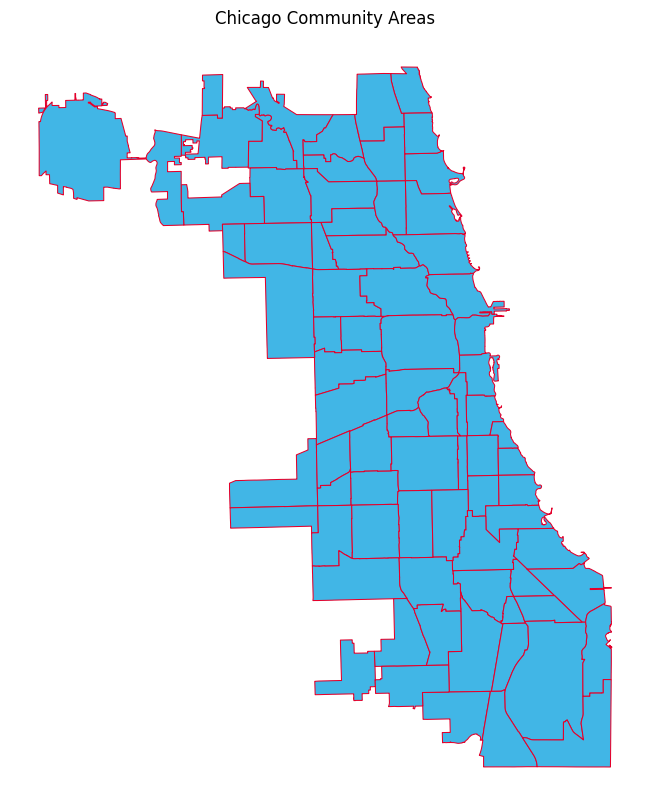

In [9]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": COLORS["blue"],
    "linewidth": 0.75,
}
ax = CAs.geometry.plot(figsize=(10,10), **kwargs)
ax.set_title("Chicago Community Areas")
ax.set_axis_off()

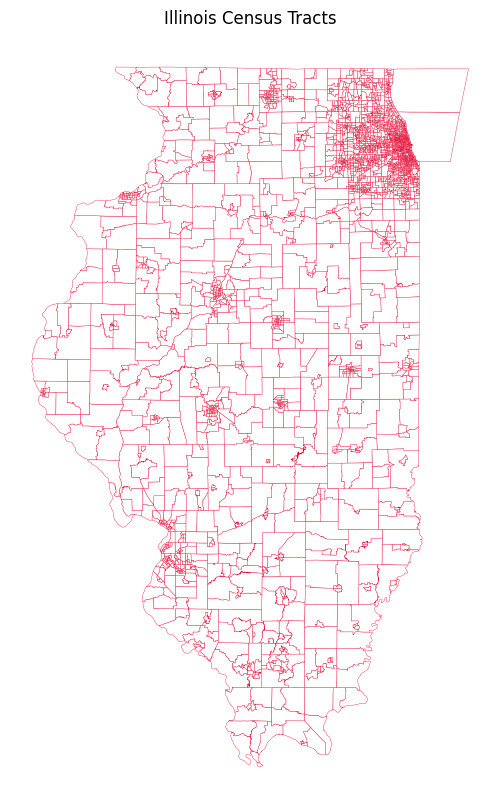

In [10]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": "#FFFFFF",
    "linewidth": 0.25,
}
ax = tracts.geometry.plot(figsize=(10,10), **kwargs)
ax.set_title("Illinois Census Tracts")
ax.set_axis_off()

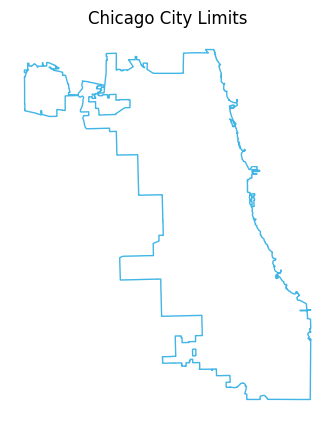

In [11]:
kwargs = {
    "edgecolor": COLORS["blue"],
    "color": "#FFFFFF",
}
ax = city.geometry.plot(figsize=(5,5), **kwargs)
ax.set_title("Chicago City Limits")
ax.set_axis_off()

## Identify Tracts within Chicago
To inspect tracts along city limits, let's bubble out around the city a bit.

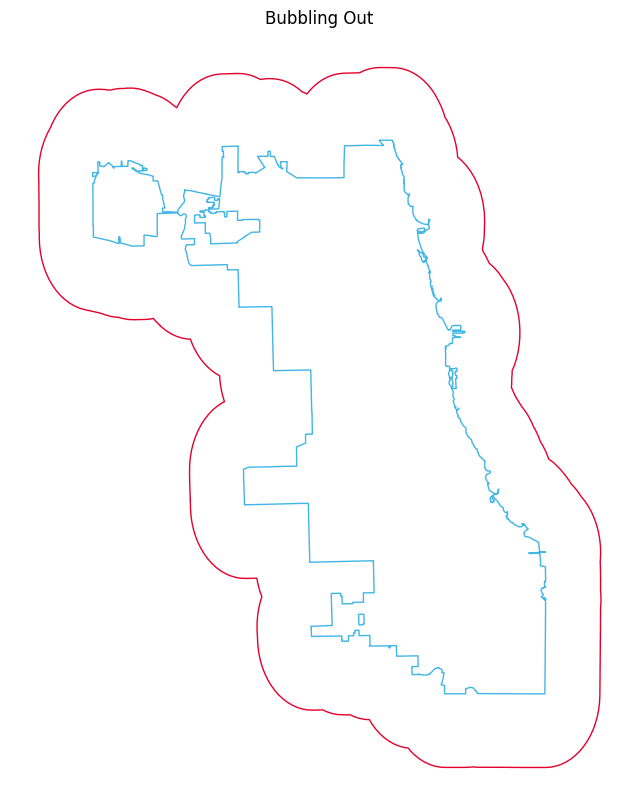

In [12]:
kwargs = {
    "edgecolor": COLORS["red"],
    "color": "#FFFFFF",
}
buffer_dist = 0.05
ax = city.geometry.buffer(buffer_dist).plot(figsize=(10,10), **kwargs)

kwargs = {
    "edgecolor": COLORS["blue"],
    "color": "#FFFFFF",
}
city.geometry.plot(ax=ax, **kwargs)

ax.set_title("Bubbling Out")
ax.set_axis_off()

#### Tracts within the Chicago "Bubble"

In [ ]:
buffer_dist = 0.05
bubble_mask = tracts.geometry.to_crs(city.geometry.crs).apply(lambda gmtry: city.geometry.buffer(buffer_dist).contains(gmtry)).values
bubble_census_tracts = tracts[bubble_mask]
bubble_census_tracts.shape[0]

In [ ]:
kwargs = {
    "edgecolor": "#FFFFFF",
    "linewidth": 3,
}
ax = bubble_census_tracts.geometry.plot(figsize=(20,20), **kwargs)

kwargs = {
    "edgecolor": "black",
    "color": (0,0,0,0), #transparent
    "linewidth": 0.5,
}
CAs.geometry.plot(ax=ax, **kwargs)

ax.set_title("Chicagoland Census Tracts Overlaid with Community Area Boundaries")
ax.set_axis_off()
# plt.savefig("../plots/tracts_and_community_areas.png", dpi=300)

#### Inspecting Tracts that don't play nice
It appears that most tracts nicely align with the borders of Community Areas. I've manually identified four that do not, but they are tracts that I expect will have no population. They are:  
- O'Hare Airport
- Midway Airport
- A stretch of the Kennedy Expressway 
- A cemetary (but they vote in Chicago!)

### Assigning Tracts to Community Areas based on Percent Overlap
Calcualte a pairwise matrix of the percent of a census tract surface area that is within each community area. I will assign each tract to the community area that it is most in. This should properly account for census tracts that span into the lake. The community area boundaries hug the shoreline, so shoreline tracts should only overlap with one community area.

### Find the Lake Tract
If we can identify that a tract borders the "lake tract", then we know to assign it's whole population to the overlapping community area.

In [ ]:
# It appears to be the second largets
tracts.geometry.area.sort_values(ascending=False).head(5)

In [ ]:
# That looks good, baby!
tracts.loc[2385].geometry

In [ ]:
lake_tract = tracts.loc[2385]

### Find the Shoreline Tracts
The ones that border the Lake Tract

In [ ]:
shoreline_tracts = bubble_census_tracts[bubble_census_tracts.geometry.touches(lake_tract.geometry)]
ax = shoreline_tracts.geometry.plot(figsize=(8,8))
ax.set_title("Census Tracts Along the Shoreline")
ax.set_axis_off()

### Calculate Percent Overlap

In [ ]:
tracts.geometry.intersection(CAs.geometry)